In [45]:
from datetime import datetime
import os
import zipfile

import joblib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.model_selection import (
    ParameterGrid,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier

import dropbox
import time
from dotenv import load_dotenv
from dropbox.files import WriteMode
from dropbox.exceptions import ApiError
from requests.exceptions import SSLError as RequestsSSLError



In [25]:
df = pd.read_csv("./assets/weatherAUS.csv.zip")

df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [26]:
df.shape

(145460, 23)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


In [29]:
df["RainTomorrow"].value_counts(normalize=True)

RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64

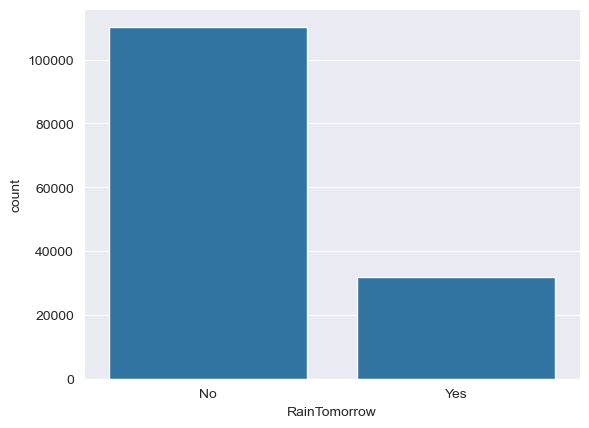

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="RainTomorrow", data=df)
plt.show()

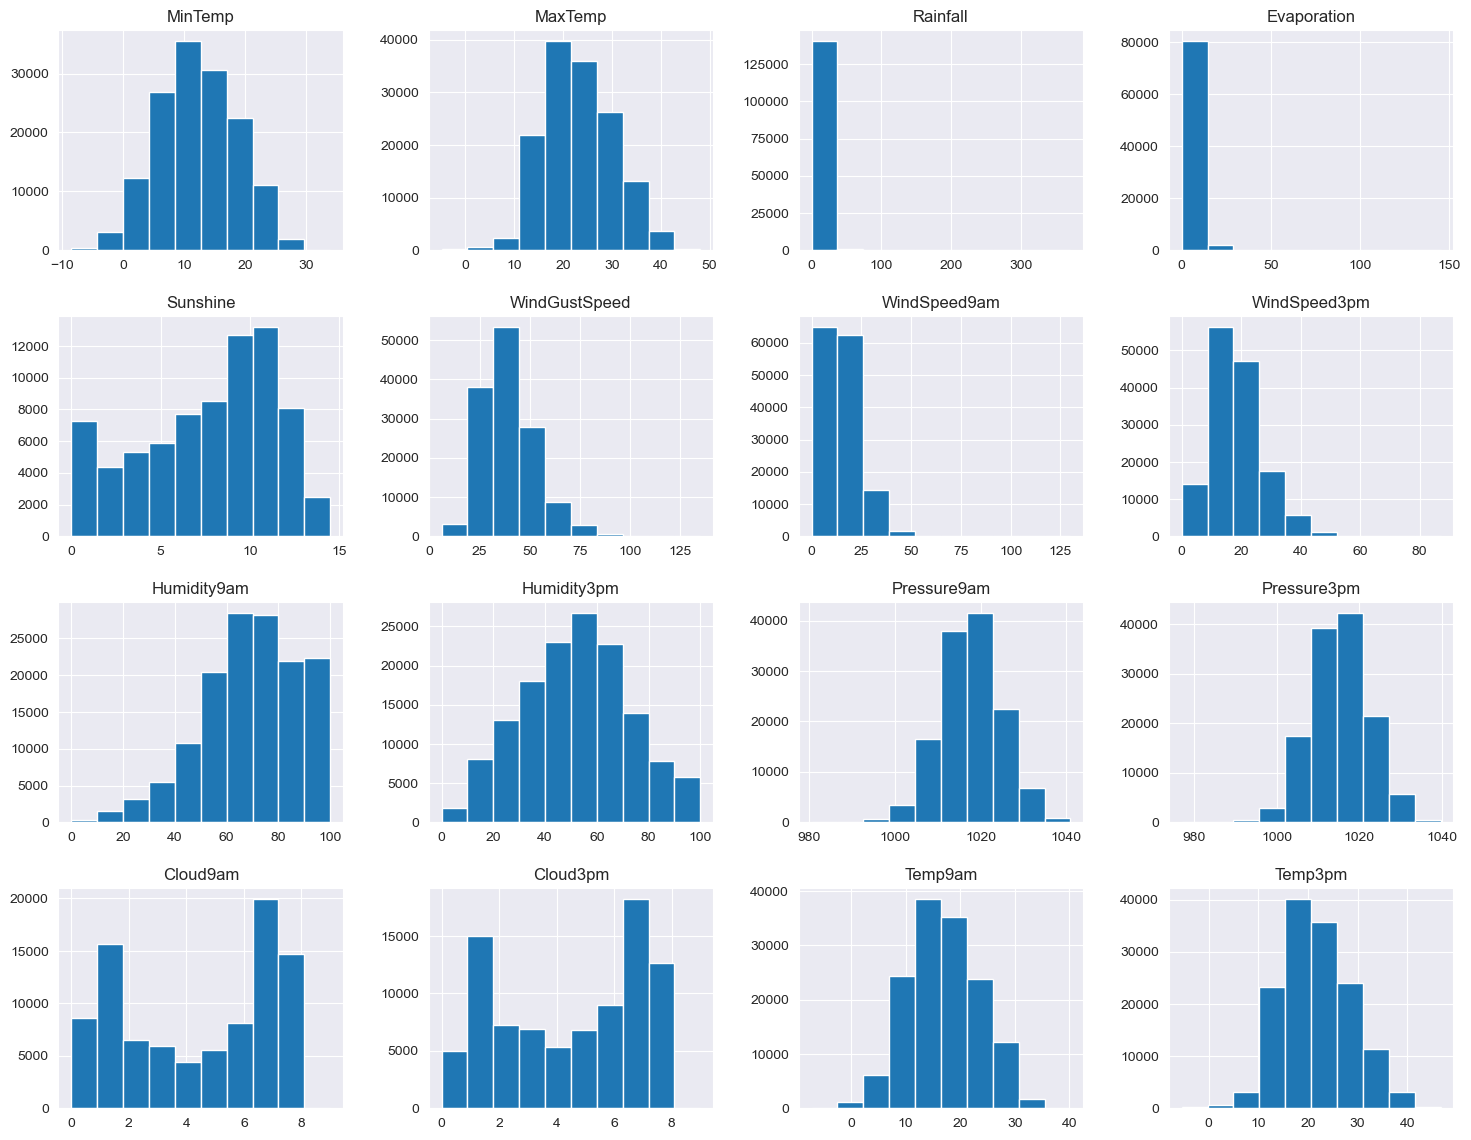

In [31]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

df[num_cols].hist(figsize=(18, 14))
plt.show()

In [32]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
dtype: float64

In [33]:

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# =========================
# 1. Train / test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 2. Helper: model evaluation
# =========================
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    return roc_auc_score(y_test, y_prob)

# =========================
# 3. Common CV settings
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "roc_auc"

# =========================
# 4. Generic tuning helper with progress bars
# =========================
def tune_model_with_progress(name, base_estimator, param_grid, X_train, y_train, cv, scoring):
    """
    Manual grid search with nested progress bars:
    - outer loop: parameter combinations
    - inner: cross_val_score with n_jobs=-1 (parallel back-end)
    """
    grid = list(ParameterGrid(param_grid))
    scores = []

    print(f"\n>>> Tuning {name} ({len(grid)} param combinations)...")

    # Progress bar over parameter combinations for this model
    pbar = tqdm(grid, desc=f"{name} grid", leave=True)

    base_params = base_estimator.get_params()

    for params in pbar:
        # Merge base params with current grid params (grid params override base)
        merged_params = {**base_params, **params}
        model = base_estimator.__class__(**merged_params)

        cv_scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = cv_scores.mean()
        scores.append((params, mean_score))

        # Update progress bar postfix with current score
        pbar.set_postfix({"cv_score": f"{mean_score:.4f}"})

    # Select best params by score
    best_params, best_score = max(scores, key=lambda x: x[1])

    print(f"\nBest params for {name}: {best_params}")
    print(f"Best CV {scoring} for {name}: {best_score:.4f}")

    # Fit final model on full train data with best params
    best_model = base_estimator.__class__(**{**base_params, **best_params})
    best_model.fit(X_train, y_train)

    return best_model, best_params, best_score

# =========================
# 5. Define models and param grids
# =========================
logreg_base = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs"
)

logreg_param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0]
}

rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# =========================
# 6. Global progress over models
# =========================
models_def = [
    ("Logistic Regression", logreg_base, logreg_param_grid),
    ("Random Forest", rf_base, rf_param_grid),
    ("XGBoost", xgb_base, xgb_param_grid),
]

best_models = {}
best_params_dict = {}
best_cv_scores = {}
roc_test_scores = {}

for name, base_est, grid in tqdm(models_def, desc="Models", leave=True):
    model_best, params_best, cv_best = tune_model_with_progress(
        name=name,
        base_estimator=base_est,
        param_grid=grid,
        X_train=X_train,
        y_train=y_train,
        cv=cv,
        scoring=scoring
    )
    best_models[name] = model_best
    best_params_dict[name] = params_best
    best_cv_scores[name] = cv_best
    roc_test_scores[name] = evaluate_model(f"{name} (tuned)", model_best, X_test, y_test)

# =========================
# 7. Final comparison table
# =========================
results = pd.DataFrame({
    "Model": list(best_models.keys()),
    "Best_CV_ROC_AUC": [best_cv_scores[m] for m in best_models.keys()],
    "Test_ROC_AUC": [roc_test_scores[m] for m in best_models.keys()],
    "Best_Params": [best_params_dict[m] for m in best_models.keys()]
}).sort_values(by="Test_ROC_AUC", ascending=False)

print("\n===== Final model comparison =====")
display(results)


In [39]:
# =========================
# 1. Train / test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 2. Helper: model evaluation
# =========================
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    return roc_auc_score(y_test, y_prob)

# =========================
# 3. Common CV settings
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "roc_auc"

# =========================
# 4. Generic tuning helper with progress bars
# =========================
def tune_model_with_progress(name, base_estimator, param_grid, X_train, y_train, cv, scoring):
    """
    Manual grid search with nested progress bars:
    - outer loop: parameter combinations
    - inner: cross_val_score with n_jobs=-1 (parallel back-end)
    """
    grid = list(ParameterGrid(param_grid))
    scores = []

    print(f"\n>>> Tuning {name} ({len(grid)} param combinations)...")

    # Progress bar over parameter combinations for this model
    pbar = tqdm(grid, desc=f"{name} grid", leave=True)

    base_params = base_estimator.get_params()

    for params in pbar:
        # Merge base params with current grid params (grid params override base)
        merged_params = {**base_params, **params}
        model = base_estimator.__class__(**merged_params)

        cv_scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = cv_scores.mean()
        scores.append((params, mean_score))

        # Update progress bar postfix with current score
        pbar.set_postfix({"cv_score": f"{mean_score:.4f}"})

    # Select best params by score
    best_params, best_score = max(scores, key=lambda x: x[1])

    print(f"\nBest params for {name}: {best_params}")
    print(f"Best CV {scoring} for {name}: {best_score:.4f}")

    # Fit final model on full train data with best params
    best_model = base_estimator.__class__(**{**base_params, **best_params})
    best_model.fit(X_train, y_train)

    return best_model, best_params, best_score

# =========================
# 5. Define models and param grids
# =========================
logreg_base = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs"
)

logreg_param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0]
}

rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# =========================
# 6. Global progress over models
# =========================
models_def = [
    ("Logistic Regression", logreg_base, logreg_param_grid),
    ("Random Forest", rf_base, rf_param_grid),
    ("XGBoost", xgb_base, xgb_param_grid),
]

best_models = {}
best_params_dict = {}
best_cv_scores = {}
roc_test_scores = {}

for name, base_est, grid in tqdm(models_def, desc="Models", leave=True):
    model_best, params_best, cv_best = tune_model_with_progress(
        name=name,
        base_estimator=base_est,
        param_grid=grid,
        X_train=X_train,
        y_train=y_train,
        cv=cv,
        scoring=scoring
    )
    best_models[name] = model_best
    best_params_dict[name] = params_best
    best_cv_scores[name] = cv_best
    roc_test_scores[name] = evaluate_model(f"{name} (tuned)", model_best, X_test, y_test)

# =========================
# 7. Final comparison table
# =========================
results = pd.DataFrame({
    "Model": list(best_models.keys()),
    "Best_CV_ROC_AUC": [best_cv_scores[m] for m in best_models.keys()],
    "Test_ROC_AUC": [roc_test_scores[m] for m in best_models.keys()],
    "Best_Params": [best_params_dict[m] for m in best_models.keys()]
}).sort_values(by="Test_ROC_AUC", ascending=False)

print("\n===== Final model comparison =====")
display(results)


Models:   0%|          | 0/3 [00:00<?, ?it/s]


>>> Tuning Logistic Regression (4 param combinations)...


Logistic Regression grid:   0%|          | 0/4 [00:00<?, ?it/s]


Best params for Logistic Regression: {'C': 10.0}
Best CV roc_auc for Logistic Regression: 0.8609

===== Logistic Regression (tuned) =====
Accuracy: 0.7865255459052709
ROC AUC: 0.8627545607075319
Confusion matrix:
[[17480  4584]
 [ 1487  4888]]
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22064
           1       0.52      0.77      0.62      6375

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.73     28439
weighted avg       0.83      0.79      0.80     28439


>>> Tuning Random Forest (24 param combinations)...


Random Forest grid:   0%|          | 0/24 [00:00<?, ?it/s]


Best params for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best CV roc_auc for Random Forest: 0.8822

===== Random Forest (tuned) =====
Accuracy: 0.853370371672703
ROC AUC: 0.8867406653016536
Confusion matrix:
[[21236   828]
 [ 3342  3033]]
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     22064
           1       0.79      0.48      0.59      6375

    accuracy                           0.85     28439
   macro avg       0.82      0.72      0.75     28439
weighted avg       0.85      0.85      0.84     28439


>>> Tuning XGBoost (32 param combinations)...


XGBoost grid:   0%|          | 0/32 [00:00<?, ?it/s]


Best params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.8}
Best CV roc_auc for XGBoost: 0.8912

===== XGBoost (tuned) =====
Accuracy: 0.826998136362038
ROC AUC: 0.895127280353766
Confusion matrix:
[[18587  3477]
 [ 1443  4932]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     22064
           1       0.59      0.77      0.67      6375

    accuracy                           0.83     28439
   macro avg       0.76      0.81      0.78     28439
weighted avg       0.85      0.83      0.83     28439


===== Final model comparison =====


,Model,Best_CV_ROC_AUC,Test_ROC_AUC,Best_Params
2,XGBoost,0.891249,0.895127,"{'colsample_bytree': 1.0, 'learning_rate': 0.1..."
1,Random Forest,0.882165,0.886741,"{'max_depth': None, 'min_samples_leaf': 1, 'mi..."
0,Logistic Regression,0.860944,0.862755,{'C': 10.0}


In [50]:
# =========================
# 0. Best params (paste from tuning step)
# =========================
# Example placeholders – replace with your actual best params
logreg_best_params = {"C": 10.0}

rf_best_params = {
    "n_estimators": 400,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1
}

xgb_best_params = {
    "n_estimators": 400,
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 1.0
}

# =========================
# 1. Train final models on full data (X, y)
# =========================
# Logistic Regression
logreg_final = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
    **logreg_best_params
)
logreg_final.fit(X, y)

# Random Forest
rf_final = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    **rf_best_params
)
rf_final.fit(X, y)

# XGBoost
pos_weight = (y == 0).sum() / (y == 1).sum()

xgb_final = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    **xgb_best_params
)
xgb_final.fit(X, y)


# =========================
# 2. Save artifacts locally
# =========================
os.makedirs("artifacts", exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

logreg_path = f"artifacts/logreg_model_{timestamp}.joblib"
rf_path = f"artifacts/rf_model_{timestamp}.joblib"
xgb_path = f"artifacts/xgb_model_{timestamp}.joblib"
features_path = f"artifacts/feature_columns_{timestamp}.joblib"
scaler_path = f"artifacts/scaler_{timestamp}.joblib"

joblib.dump(logreg_final, logreg_path)
joblib.dump(rf_final, rf_path, compress=("gzip", 3))
joblib.dump(xgb_final, xgb_path)
joblib.dump(list(X.columns), features_path)

# Save scaler if it exists in current namespace (from preprocessing step)
if "scaler" in globals():
    joblib.dump(scaler, scaler_path)
    saved_files = [logreg_path, rf_path, xgb_path, features_path, scaler_path]
else:
    saved_files = [logreg_path, rf_path, xgb_path, features_path]

print("Saved local artifacts:")
for p in saved_files:
    print(" -", p)


# =========================
# 3. Upload artifacts to Dropbox (with retry + chunked upload)
# =========================
load_dotenv()

DROPBOX_ACCESS_TOKEN = os.getenv("DROPBOX_ACCESS_TOKEN")
DROPBOX_FOLDER = os.getenv("DROPBOX_FOLDER")

if DROPBOX_ACCESS_TOKEN is None:
    raise ValueError("Dropbox token not found in .env")

print("Dropbox token loaded from .env")

dbx = dropbox.Dropbox(DROPBOX_ACCESS_TOKEN)

CHUNK_SIZE = 4 * 1024 * 1024  # 4 MB
MAX_RETRIES = 3

def upload_file_resumable(dbx, local_path, dropbox_path):
    file_size = os.path.getsize(local_path)

    for attempt in range(1, MAX_RETRIES + 1):
        try:
            with open(local_path, "rb") as f, tqdm(
                total=file_size,
                unit="B",
                unit_scale=True,
                unit_divisor=1024,
                desc=os.path.basename(local_path),
                leave=True
            ) as pbar:

                if file_size <= CHUNK_SIZE:
                    data = f.read()
                    dbx.files_upload(
                        data,
                        dropbox_path,
                        mode=WriteMode("overwrite")
                    )
                    pbar.update(len(data))
                else:
                    upload_session_start = dbx.files_upload_session_start(
                        f.read(CHUNK_SIZE)
                    )
                    pbar.update(f.tell())

                    cursor = dropbox.files.UploadSessionCursor(
                        session_id=upload_session_start.session_id,
                        offset=f.tell(),
                    )

                    commit = dropbox.files.CommitInfo(
                        path=dropbox_path,
                        mode=WriteMode("overwrite")
                    )

                    while f.tell() < file_size:
                        chunk = f.read(CHUNK_SIZE)

                        if (file_size - cursor.offset) <= CHUNK_SIZE:
                            dbx.files_upload_session_finish(
                                chunk,
                                cursor,
                                commit
                            )
                        else:
                            dbx.files_upload_session_append_v2(
                                chunk,
                                cursor
                            )
                            cursor.offset += len(chunk)

                        pbar.update(len(chunk))

            print(f"Uploaded: {local_path} -> {dropbox_path}")
            return

        except (ApiError, RequestsSSLError) as e:
            print(f"[{attempt}/{MAX_RETRIES}] Upload failed for {local_path}: {e}")
            time.sleep(2)

    print(f"FAILED after retries: {local_path}")

for local_path in saved_files:
    filename = os.path.basename(local_path)
    dropbox_path = f"{DROPBOX_FOLDER}/{filename}"
    upload_file_resumable(dbx, local_path, dropbox_path)


Saved local artifacts:
 - artifacts/logreg_model_20251206_171750.joblib
 - artifacts/rf_model_20251206_171750.joblib
 - artifacts/xgb_model_20251206_171750.joblib
 - artifacts/feature_columns_20251206_171750.joblib
 - artifacts/scaler_20251206_171750.joblib
Dropbox token loaded from .env


logreg_model_20251206_171750.joblib:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Uploaded: artifacts/logreg_model_20251206_171750.joblib -> /weather-ml-upload/logreg_model_20251206_171750.joblib


rf_model_20251206_171750.joblib:   0%|          | 0.00/308M [00:00<?, ?B/s]

Uploaded: artifacts/rf_model_20251206_171750.joblib -> /weather-ml-upload/rf_model_20251206_171750.joblib


xgb_model_20251206_171750.joblib:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Uploaded: artifacts/xgb_model_20251206_171750.joblib -> /weather-ml-upload/xgb_model_20251206_171750.joblib


feature_columns_20251206_171750.joblib:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

Uploaded: artifacts/feature_columns_20251206_171750.joblib -> /weather-ml-upload/feature_columns_20251206_171750.joblib


scaler_20251206_171750.joblib:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Uploaded: artifacts/scaler_20251206_171750.joblib -> /weather-ml-upload/scaler_20251206_171750.joblib
